# Problem Statement
The main challenges comprise of classifying the products into right categories and matching the exact same products across different retailers for price comparison.

This problem comes under the category of multi-label classification and product retrieval. Sometimes product's textual data (product title & description) is helpful for this task, and sometimes product's images help. Hence, to classify the products into the right category build a Deep Learning multi-modal which incorporates images as well as text for the classification of the Product.

# Guidance:
While creating the multi-modal classifier we are going to refer HUSE research paper for better understanding and enhancement in the network of multi-modal.
**HUSE: Hierarchical Universal Semantic Embeddings** (https://arxiv.org/pdf/1911.05978.pdf)

![alt text](https://drive.google.com/uc?id=1ZNSwXlziS7DOPyqXrHROLnEpyHmQwxht)

# Notebook has Following Section to achieve this task:
1. Downloading of the Data to Google Drive and unzipping it i.e. Images and Text Files.
2. Loading the Images.
3. Selecting the Pre-Trained Model for the Image Classification.
4. Loading the Text Files.
5. Selecting the Pre-Trained Model for creating Embeddings of the Sentences.
6. Spliting the Image and Text into Train and Test data.
7. Combining the Model output from Image model and Text Model and Building  Universal Embedding Space.
8. Training the Final Model on the Training Data.


# 1. Unzipping the Data

In [0]:
# !unzip "/content/drive/My Drive/HUSE/images.zip" -d "/content/drive/My Drive/HUSE/unzipped_images"

In [0]:
#Importing the Libraries

import os
import pandas as pd
import numpy as np

Extracting the Images Name from the Directory to match it with the Image's Name in the Text File.

In [0]:
#Extracting the Images Name from the Drive Location
from glob import iglob
pth ="/content/drive/My Drive/HUSE/unzipped_images/content/netaporter_gb_images/"
# print(list(map(os.path.basename,iglob(pth+"*.jpg"))))


print([os.path.basename(f) for f in  iglob(pth+"*.jpg")])


['5e5d4feb2886bf988492bc69_2.jpg', '5e5d4feb2886bf988492bc5b_3.jpg', '5e5d4feb2886bf988492bc67_3.jpg', '5e5d4feb2886bf988492bc5f_1.jpg', '5e5d4feb2886bf988492bc5d_3.jpg', '5e5d4feb2886bf988492bc63_2.jpg', '5e5d4feb2886bf988492bc5f_3.jpg', '5e5d4feb2886bf988492bc5c_2.jpg', '5e5d4feb2886bf988492bc55_2.jpg', '5e5d4feb2886bf988492bc69_1.jpg', '5e5d4feb2886bf988492bc68_2.jpg', '5e5d4feb2886bf988492bc6a_1.jpg', '5e5d4feb2886bf988492bc5c_3.jpg', '5e5d4feb2886bf988492bc67_0.jpg', '5e5d4feb2886bf988492bc62_0.jpg', '5e5d4feb2886bf988492bc6c_3.jpg', '5e5d4feb2886bf988492bc61_1.jpg', '5e5d4feb2886bf988492bc6a_3.jpg', '5e5d4feb2886bf988492bc6e_3.jpg', '5e5d4feb2886bf988492bc65_2.jpg', '5e5d4feb2886bf988492bc73_2.jpg', '5e5d4feb2886bf988492bc73_3.jpg', '5e5d4feb2886bf988492bc7a_0.jpg', '5e5d4feb2886bf988492bc78_2.jpg', '5e5d4feb2886bf988492bc79_0.jpg', '5e5d4feb2886bf988492bc76_1.jpg', '5e5d4feb2886bf988492bc73_1.jpg', '5e5d4feb2886bf988492bc84_3.jpg', '5e5d4feb2886bf988492bc80_3.jpg', '5e5d4feb2886

In [0]:
#Number of the Images in the Directory
image_name = [os.path.basename(f) for f in  iglob(pth+"*.jpg")]
len(image_name)


32483

In [0]:
# Reading the Text File.
data = pd.read_csv("/content/drive/My Drive/HUSE/training_data.csv")
data.head()

,image,text,classes
0,5da81ef27861c2af6a5a9215_0.jpg,Christian Louboutin Lady See 85 patent textur...,shoes<boots<ankle
1,5da821e5b25b035d1d17bce2_2.jpg,"NARS Gentle Oil-Free Eye Makeup Remover, 100ml",beauty<makeup<removers
2,5da81f227861c2af6a5a9484_1.jpg,Lilah B. Eye & Lip Liner Brush #5,beauty<tools and devices<makeup brushes
3,5db8119ad5424ee1f3353153_1.jpg,adidas Originals Magmur Runner mesh and leath...,shoes<sneakers<low top
4,5da81cd67861c2af6a5a8871_2.jpg,Theory Adrianna cashmere sweater,clothing<knitwear<medium knit


In [0]:
#Converting the Image Name Extracted from the Directory to Dataframe.
image_name = pd.DataFrame(image_name).sort_values(by = 0)
image_name.head()

,0
32466,5da816f86504fb65cea6fed4_0.jpg
23206,5da816f86504fb65cea6fed4_1.jpg
23246,5da816f86504fb65cea6fed5_2.jpg
16830,5da816f86504fb65cea6fed8_2.jpg
28806,5da816f86504fb65cea6fed9_0.jpg


In [0]:
filtered_images = data[data["image"].isin(image_name[0])].sort_values(by = "image", ascending = True)
filtered_images.head()

,image,text,classes
1482,5da816f86504fb65cea6fed4_0.jpg,Gucci Leather-trimmed logo-print canvas espad...,shoes<espadrilles<flats
46190,5da816f86504fb65cea6fed4_1.jpg,Gucci Leather-trimmed logo-print canvas espad...,shoes<espadrilles<flats
34276,5da816f86504fb65cea6fed5_2.jpg,Jimmy Choo Cruz crystal-embellished textured-...,shoes<boots<ankle
695,5da816f86504fb65cea6fed8_2.jpg,Alexander McQueen Striped cable-knit cashmere...,accessories<scarves<scarves
27506,5da816f86504fb65cea6fed9_0.jpg,Alexander Wang Ryan leather belt bag,bags<belt bags<belt bags


#2. Selection Of Pre-Trained Model for Image.
For creating the Embedding of the Image we are using Transfer Learning approach. Transfer Learning focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. 

So, For creating the Image Embeddings we are going to use VGG-16 Pre-Trained Model and remove the last Fully Connected Layer from the model and Later on we will add Fully Connected Layer according to the HUSE reasearch Paper and Freeze the Model Training of the already Trained weights of the VGG-16 Model.

**Following Image shows an General architecture of the VGG-16 Model**
![alt text](https://drive.google.com/uc?id=1RHENaki77DQaNzk7oomI7446P2z6ayXa)

In [0]:
#Importing the necessary Library
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers 
from tensorflow.keras.layers import Input

In [0]:
#resizing the image size
IMAGE_SIZE = [224, 224]


In [0]:
# Add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [0]:
# Not training  existing weights
for layer in vgg.layers:
  layer.trainable = False

In [0]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Following Image represents the systematic view for the implementation of the multi-modal.
![alt text](https://drive.google.com/uc?id=1QeOEVE2WrvbVKyR9UdG1W6gctfERwl5_)


# Image Embeddings

In [0]:
# Flattening the Output of the VGG-16
flatten_images = Flatten()(vgg.output)



# Image Tower Creation (as per the HUSE Reasearch Paper)
The image tower consists of 5 hidden layers of 512 hidden
units each.A dropout of 0.15 is used between all
hidden layers of the image Tower and at the Final Layer **L2 Regularization** has been applied.

In [0]:
#Creating the Fully Connected Layer to Pass Flattened output to these Fully connected Layer.
#These are Layer are Formed According to the HUSE Resarch Paper.
fc= Dense(512, activation = "relu",kernel_initializer = "he_uniform",name ="fc_1")(flatten_images)
fc = Dropout(0.15)(fc)
fc = Dense(512, activation = "relu",kernel_initializer = "he_uniform",name = "fc_2")(fc)
fc = Dropout(0.15)(fc)
fc = Dense(512, activation = "relu",kernel_initializer = "he_uniform",name = "fc_3")(fc)
fc = Dropout(0.15)(fc)
fc = Dense(512, activation = "relu",kernel_initializer = "he_uniform",name = "fc_4")(fc)
fc = Dropout(0.15)(fc)
fc = Dense(512, activation = "relu",kernel_initializer = "he_uniform",activity_regularizer= regularizers.l2(0.01),name = "fc_5")(fc)
# fc= Dense(224,activation="softmax")(fc)


#creating model 
image_model = Model(inputs = vgg.input, outputs = fc)
image_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# image_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# image_model.fit(image_train,y_train, batch_size=100,epochs=10)

#3.Loading the Image data
We are going to load only 5000 Images from the directory for the perforamnce reason and convert it into the array and save these arrays in .npy file format so that the Image Loading Time shouldn't be elapsed. 

**I have commented the following code so that it Loading of the Image from the directory shouldn't start again, instead we can Load the already saved array for reuse of the Data.**
![alt text](https://drive.google.com/uc?id=1G5TBLJsP4yVnx6CrNs5wAAPfz3bwGxyY)

In [0]:
# # Loading the training data

# from tqdm import tqdm


# img_data_list=[]

# for img in tqdm(filtered_images["image"].iloc[:5000]):
#   img_path = '/content/drive/My Drive/HUSE/unzipped_images/content/netaporter_gb_images/{}'.format(img)
#   img = image.load_img(img_path, target_size=(224, 224))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)
#   # x = preprocess_input(x)
#   x = x/255
#   # print('Input image shape:', x.shape)
#   img_data_list.append(x)

In [0]:
# img_data_list

In [0]:
# #Converting the image arrays to numpy array and saving the in binary .npy format.
# img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
# # save to npy file
# from numpy import save
# save('img_data.npy', img_data)


In [0]:
#Loading the images array from the .npy file saved in Google Drive.
from numpy import load
img_data = load("/content/drive/My Drive/HUSE/img_data1.npy")
img_data = img_data.astype("float32")

In [0]:
#Changing the shape of the Image array.
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

(5000, 1, 224, 224, 3)
(1, 5000, 224, 224, 3)
(5000, 224, 224, 3)


In [0]:
len(img_data)

5000

In [0]:
vgg.output_shape

(None, 7, 7, 512)

# Text Classification 
![alt text](https://drive.google.com/uc?id=1i7-vWQe3GPB3zQMAWxgHrBMaORVcCZbl)

In [0]:
filtered_images.head()

,image,text,classes
1482,5da816f86504fb65cea6fed4_0.jpg,Gucci Leather-trimmed logo-print canvas espad...,shoes<espadrilles<flats
46190,5da816f86504fb65cea6fed4_1.jpg,Gucci Leather-trimmed logo-print canvas espad...,shoes<espadrilles<flats
34276,5da816f86504fb65cea6fed5_2.jpg,Jimmy Choo Cruz crystal-embellished textured-...,shoes<boots<ankle
695,5da816f86504fb65cea6fed8_2.jpg,Alexander McQueen Striped cable-knit cashmere...,accessories<scarves<scarves
27506,5da816f86504fb65cea6fed9_0.jpg,Alexander Wang Ryan leather belt bag,bags<belt bags<belt bags


In [0]:
#Resetting the index
filtered_images = filtered_images.reset_index()

In [0]:
#Dropping the old Index
filtered_images.drop("index", axis = 1, inplace=True)

In [0]:
filtered_images.head()

,image,text,classes
0,5da816f86504fb65cea6fed4_0.jpg,Gucci Leather-trimmed logo-print canvas espad...,shoes<espadrilles<flats
1,5da816f86504fb65cea6fed4_1.jpg,Gucci Leather-trimmed logo-print canvas espad...,shoes<espadrilles<flats
2,5da816f86504fb65cea6fed5_2.jpg,Jimmy Choo Cruz crystal-embellished textured-...,shoes<boots<ankle
3,5da816f86504fb65cea6fed8_2.jpg,Alexander McQueen Striped cable-knit cashmere...,accessories<scarves<scarves
4,5da816f86504fb65cea6fed9_0.jpg,Alexander Wang Ryan leather belt bag,bags<belt bags<belt bags


# TEXT Cleaning:
Removing all the unecessary text, punctuations and numbers which are irrelevant for the classification task.

In [0]:
#Cleaning of The Text 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
sentence = []
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wl  = WordNetLemmatizer()
import re
from tqdm import tqdm
for text in tqdm(filtered_images["text"]):
  text = re.sub("[^a-zA-Z]", " ", text)
  text = text.lower()
  text = text.split()
  text = [wl.lemmatize(word) for word in text if word not in set(stopwords.words("english"))]
  text = [word for word in text if len(word)>2]
  sentence.append(" ".join(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


  0%|          | 0/32483 [00:00<?, ?it/s]

[nltk_data]   Package wordnet is already up-to-date!


100%|██████████| 32483/32483 [00:27<00:00, 1163.59it/s]


In [0]:
#Saving the cleaned TEXT in new column. 
filtered_images["cleaned_text"] = sentence

In [0]:
filtered_images.head()

,image,text,classes,cleaned_text
0,5da816f86504fb65cea6fed4_0.jpg,Gucci Leather-trimmed logo-print canvas espad...,shoes<espadrilles<flats,gucci leather trimmed logo print canvas espadr...
1,5da816f86504fb65cea6fed4_1.jpg,Gucci Leather-trimmed logo-print canvas espad...,shoes<espadrilles<flats,gucci leather trimmed logo print canvas espadr...
2,5da816f86504fb65cea6fed5_2.jpg,Jimmy Choo Cruz crystal-embellished textured-...,shoes<boots<ankle,jimmy choo cruz crystal embellished textured l...
3,5da816f86504fb65cea6fed8_2.jpg,Alexander McQueen Striped cable-knit cashmere...,accessories<scarves<scarves,alexander mcqueen striped cable knit cashmere ...
4,5da816f86504fb65cea6fed9_0.jpg,Alexander Wang Ryan leather belt bag,bags<belt bags<belt bags,alexander wang ryan leather belt bag


In [0]:
# #Splitting into Train and Text
# x_train = filtered_images["cleaned_text"].str.strip().iloc[:25986]
# y_train = filtered_images["classes"].iloc[:25986]
# x_test = filtered_images["cleaned_text"].str.strip().iloc[25986:]
# y_test = filtered_images["classes"].iloc[25986:]

In [0]:
# count = []
# for x in filtered_images["text"]:
#   count.append(len(x))
# print(count)

In [0]:
# from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences
# vocab_size = 20000
# encoded_train= [one_hot(d, vocab_size) for d in ]
# encoded_test = [one_hot(d, vocab_size) for d in x_test]

In [0]:
# from tensorflow.keras.layers import Embedding
# embedding_length = 10
# max_doc_len = 80
# encoded_train= pad_sequences(encoded_train, max_doc_len, truncating="post")
# encoded_test= pad_sequences(encoded_test, max_doc_len, truncating="post")


# #model building
# model = Sequential()
# model.add(Embedding(vocab_size, embedding_length, input_length = max_doc_len))
# model.add(Dense(512, activation="relu", name = "fc1"))
# model.add(Dropout(0.15))
# model.add(Dense(512, activation="relu",activity_regularizer=regularizers.l2(0.01),name = "fc2_regualrized"))
# model.compile("rmsprop","mse")
# output_train= model.predict(encoded_train)
# output_test= model.predict(encoded_test)

In [0]:
# model.summary()

# Building WordCloud

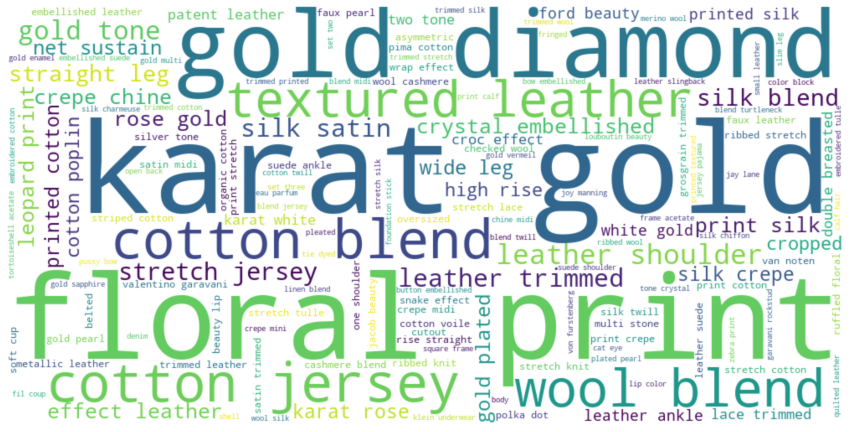

In [0]:
corpus_string = "".join(sentence)
from wordcloud import WordCloud
word_cloud = WordCloud(width=1000, height=500,background_color="white", max_words= 150).generate(corpus_string)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(word_cloud, interpolation="gaussian")
plt.show()

# 5. Selecting the Pre-Trained models for Creating the Text Emebeddings:
For creating the text embeddings we are going to "Transformers" Library, which consists of collection of Pre-Trained models such as BERT, DistilBert,RObert, GPT, etc.. 

In [0]:
#Installing the Transformers Library
!pip install transformers


In [0]:
import torch
import transformers as ppb


# Loading the Pre-trained model for TEXT

We are Loading **DistilBert Model** for pretrained model instead of **BERT** Model.

**DistilBERT** processes the sentence and passes along some information it extracted from it on to the next model. **DistilBERT** is a smaller version of **BERT** developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.

Before applying any Pre-Trained Model we need to convert the input in the formate of the input model accepts. Following are the process done on the Text Before applying **DistilBert** or **BERT** model:

1. **Tokenization** of the sentence i.e seperating each word of the sentence with space.
2. Adding the  **[CLS]** at the starting of the sentence which denotes "CLASSIFIER" and **[SEP]**at the end of the sentence which denotes the Seperater of the sentence from the other sentence.
3.Replace each token with its **id** from the Embedding table which is a component we get with the trained model.
4.Adding **Padding** to the Sentences so the length of different sentence becomes equal.

Below Image shows a proper visualization of the application of the pre-Trained Model.


![alt text](https://drive.google.com/uc?id=1_yzzA5LFzOL5Qv8cU9I_Y4_vnM_h5DB8)

In [0]:
#Loading the Model, Tokenizer and Pretrained weights
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

We are going to use only 5000 images and repective 5000 description of the Images from text file for the training of the Images due to performance reasons.

In [0]:
#Tokenizing and Encoding the Text data
tokenized = filtered_images["cleaned_text"].iloc[:5000].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))



In [0]:
#Padding the Sentences with Zeroes 
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [0]:
#Shape og the Padded Sentence.
np.array(padded).shape

(5000, 23)

# MASKING:
If we directly send padded sentence to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [0]:
#MASKING
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(5000, 23)

Now that we have our model and inputs ready, let's run our model!



The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

In [0]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [0]:
#Extracting the hidden states (Embeddings) and converting the Tensors to numpy array's as after fitting to the model it produces the output in form of Tensors.
numpy_hidden_states = last_hidden_states[0][:].numpy()
numpy_hidden_states.shape

(5000, 23, 768)

In [0]:
#Printing the Datatype of the Embeddings.
numpy_hidden_states.dtype

dtype('float32')

# TEXT Tower Creation (as per the HUSE research Paper):
The text tower consists of 2 hidden layers of 512
hidden units each. A dropout of 0.15 is used between all
hidden layers.

In [0]:
#Text Tower Creation
from tensorflow.keras.layers import Input
input_layer = Input(shape=(23,768), dtype = "float32")

text_model = Flatten()(input_layer)
text_model = Dense(512,activation="relu",kernel_initializer = "he_uniform",name = "fc1")(text_model)
text_model = Dropout(0.15)(text_model)
text_model = Dense(512, activation="relu",kernel_initializer = "he_uniform",activity_regularizer=regularizers.l2(0.01),name = "fc2_regualrized")(text_model)
# text_model = Dense(224,activation="softmax")(text_model)
text_model = Model(inputs = input_layer, outputs = text_model)
text_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 23, 768)]         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 17664)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               9044480   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc2_regualrized (Dense)      (None, 512)               262656    
Total params: 9,307,136
Trainable params: 9,307,136
Non-trainable params: 0
_________________________________________________________________


In [0]:
# text_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# text_model.fit(numpy_hidden_states_train,y_train, batch_size=10,epochs=100)

#6.Splitting of the Image and Text Data.
We are splitting the 5000 images and respetive 5000 Text into **80**% **Train** Data and **20**% **test** data and before fitting the model we using **10**% **validation** **data**.
![alt text](https://drive.google.com/uc?id=18e49fTp9o8uAeHb-ADUbBZq5Ct-Y4cjr)

### Splitting of Image Data

In [0]:
#Train and test split
image_train = img_data[:4000]
image_test = img_data[4000:5001]

### Splitting of the Text Data

In [0]:
numpy_hidden_states_train = numpy_hidden_states[:4000]
numpy_hidden_states_test = numpy_hidden_states[4000:5001]


### Converting the Target Labels to LabelEncoder and One-Hot vectors and Spliting the Target Variable to train and test.

In [0]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

y_train= to_categorical(LabelEncoder().fit_transform(filtered_images["classes"].iloc[:4000]))
y_test = to_categorical(LabelEncoder().fit_transform(filtered_images["classes"].iloc[4000:5001]))

Using TensorFlow backend.


In [0]:
image_model.output_shape

(None, 512)

In [0]:
text_model.output_shape

(None, 512)

In [0]:
!pwd

/content


In [0]:
os.chdir('/content/drive/My Drive')

In [0]:
!pwd

/content/drive/My Drive


# 7. Combining the Model output from Image model and Text Model and Building Universal Embedding Space.

Refering to the HUSE research Paper we are building the UNIVERSAL EMBEDDING SPACE where the output from Image model i.e Image Embedding and output from the Text model i.e Text Embedding are combined and passed to the common Fully Connected Layer used for Classification by using "**SOFTMAX**" as an activation function which predicts probabilty of each class for that particular combined embeddings and selecting the maximum of those probabilites and classifying the task.


### **LOSS FUNCTIONS**:
**1.Class Level Similarity:**

HUSE passes the embeddings from image tower and text
tower through a shared fully connected layer and the model is
trained using **softmax cross entropy loss**. This discriminative
learning objective can cluster the embeddings corresponding to a class together and is easy to train than the usual
metric learning objectives. Moreover, the network can also
simultaneously do multimodal classification.

**2.Semantic Similarity:**

To make the learned universal embedding space semantically
meaningful, where embeddings corresponding to two semantically similar classes are closer than the embeddings corresponding to two semantically different classes, we regularize the embedding space using the semantic graph.

For Semantic Similarity we are going to use the journal from **SIAMESE Network**.The SIAMESE network which uses word vectors for measuring the similarity and as the word vectors i.e Embeddings are being used so the semantic similarity is also being calculated. 

**3. Cross Modal Gap:**

To reduce the cross modal gap, the distance between image
and text embeddings corresponding to the same instance
should be minimized.The loss function is used to
achieve instance level similarity is simple **"COSINE SIMILARITY"**.

In [0]:
from tensorflow.keras.layers import concatenate
from siamese_network_semantic import SiameseLSTMw2v
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import cosine_similarity

#Concatenating the output from the image model and text model.
combined = concatenate([image_model.output, text_model.output])

#preparing the UNIVERSAL EMBEDDING SPACE.
z = Dense(512,activation="relu",kernel_initializer = "he_uniform")(combined)
z = Dense(512, activation = "relu",kernel_initializer = "he_uniform")(z)
z = Dense(224,activation="softmax")(z)

#Creating the FINAL MODEL
final_model = Model(inputs=[image_model.input, text_model.input], outputs=z)

#compiling the model
final_model.compile(optimizer='rmsprop',
              loss=[categorical_crossentropy,SiameseLSTMw2v, cosine_similarity],
              metrics=['accuracy'])


In [0]:
#model Summary
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
#Checking the usage of the GPU 
!nvidia-smi

Wed Apr 15 11:00:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    26W /  75W |    715MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 8.Training the Final Model on the Training Data.

In [0]:
final_model.fit([image_train,numpy_hidden_states_train],y_train,validation_split = 0.10,batch_size=20, epochs=20, verbose=2)

Epoch 1/20
180/180 - 31s - loss: 5.5088 - accuracy: 0.0925 - val_loss: 4.3139 - val_accuracy: 0.1625
Epoch 2/20
180/180 - 31s - loss: 3.9921 - accuracy: 0.1961 - val_loss: 3.7512 - val_accuracy: 0.2025
Epoch 3/20
180/180 - 31s - loss: 3.5803 - accuracy: 0.2408 - val_loss: 3.5162 - val_accuracy: 0.2525
Epoch 4/20
180/180 - 31s - loss: 3.3598 - accuracy: 0.2700 - val_loss: 3.4284 - val_accuracy: 0.2725
Epoch 5/20
180/180 - 31s - loss: 3.1797 - accuracy: 0.2989 - val_loss: 3.1847 - val_accuracy: 0.3050
Epoch 6/20
180/180 - 31s - loss: 3.0571 - accuracy: 0.3108 - val_loss: 3.1093 - val_accuracy: 0.3325
Epoch 7/20
180/180 - 31s - loss: 2.9475 - accuracy: 0.3253 - val_loss: 3.0097 - val_accuracy: 0.3350
Epoch 8/20
180/180 - 31s - loss: 2.8362 - accuracy: 0.3325 - val_loss: 3.3195 - val_accuracy: 0.3025
Epoch 9/20
180/180 - 31s - loss: 2.7397 - accuracy: 0.3586 - val_loss: 2.9228 - val_accuracy: 0.3400
Epoch 10/20
180/180 - 31s - loss: 2.6961 - accuracy: 0.3606 - val_loss: 2.9036 - val_accura

# **Disclaimer:**
**As I have used only 5000 Images and Respective TEXT due to Resource management and proper functioning of the model. Model accuracy can be further improved by using all the DATA and Hyperparameter tuning.**